In [1]:
import cv2
import json
import os
import numpy as np

from sklearn.cluster import KMeans

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from skimage.filters.rank import entropy
from skimage.morphology import disk

import matplotlib.pyplot as plt

In [10]:
def annotation_file_info(dataset_path):
    
    # dataset folder has 
    # images folder
    # annotations.json file
    dataset_folder = os.listdir(dataset_path)

    anno_file_name = dataset_folder[1]

    with open(f"{dataset_path}/" + anno_file_name, "r") as file:
        anno_file_content = json.load(file)


    # class map is a mapping that maps class to a unique number
    class_map = {}
    for category_info in anno_file_content["categories"]:
        # print(category_info["name"])
        class_map[category_info["id"]] = category_info["name"]

    
    # image address map
    # will map the address of an image to a unique number
    image_address_map = {}

    for image_info in anno_file_content["images"]:
        image_path = dataset_path + "/images/" + image_info["file_name"]
        image_address_map[image_info["id"]] = image_path

    return (class_map, image_address_map, anno_file_content)

In [4]:
dataset_path = "./dataset/dataset-1"


In [5]:
# print(anno_file_content.keys())

In [6]:
def show_image(image, message, wait_key = 0):
    cv2.imshow(message, image)
    cv2.waitKey(wait_key)
    cv2.destroyAllWindows()

In [7]:
def give_annotated_object_area(image, segmentations):
    # now we try to segment the object from the rest of the image using the point stored in segmentations
    points = np.array(segmentations, dtype=np.int32).reshape(-1, 2)

    # initial_mask is the mask on the polygon 
    initial_mask = np.zeros(image.shape[:2], dtype=np.uint8)


    # fillPoly will fill the inside of the polygon with white color
    cv2.fillPoly(initial_mask, [points], 255)



    # anno_object stores the annotation polygon superimposed on the image
    anno_object = cv2.bitwise_and(image, image, mask=initial_mask)
    return anno_object

    



In [ ]:

def preprocessing_image(anno_object):
    show_image(anno_object, "before preprocessing")

    k = input("k = ")

    if k != '':
        pixels = anno_object.reshape(-1, 3)
        kmean = KMeans(n_clusters=int(k), random_state=42)
        labels = kmean.fit_predict(pixels)

        
        centers = kmean.cluster_centers_.astype("uint8")

        labels_2d = labels.reshape(anno_object.shape[:2])


        while(True):
            # display the clusters
            cluster = input("label = ")

            if cluster == '':
                break

            leaf_mask = (labels_2d == int(cluster)).astype(np.uint8)

            plt.imshow(leaf_mask)
            plt.axis('off')
            plt.colorbar()  # optional, shows the cluster values
            plt.show()

        leaf_filter = cv2.bitwise_and(anno_object, anno_object, mask=leaf_mask)

        # show_image(leaf_filter, "leaf filter")
    else:
        leaf_filter = anno_object

    return leaf_filter





def leaf_region_property(leaf_region, leaf_filter_gray):
    area = leaf_region.area
    perimeter = leaf_region.perimeter


    # compactness
    compactness = (perimeter ** 2) / area

    # circularity
    circularity = 4 * np.pi * area / (perimeter ** 2)

    # entropy
    normal_leaf_image = (leaf_filter_gray / leaf_filter_gray.max() * 255).astype(np.uint8)
    ent = entropy(normal_leaf_image, disk(5))
    entropy_value = np.mean(ent)

    return (compactness, circularity, entropy_value, normal_leaf_image)

def _glcm(normal_leaf_image):
    # energy
    glcm = graycomatrix(normal_leaf_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    energy = graycoprops(glcm, 'energy')[0, 0]

    return (glcm, energy)


    # # Extract GLCM only from the leaf region
    # masked = cv2.bitwise_and(normal_leaf_image, normal_leaf_image, mask=binary_leaf_filter.astype(np.uint8))

    # # Crop to bounding box to reduce empty space
    # minr, minc, maxr, maxc = leaf_region.bbox
    # cropped = masked[minr:maxr, minc:maxc]

    # # === Compute GLCM ===
    # glcm = graycomatrix(cropped, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # # === Feature 2: Homogeneity ===

    # # === Feature 3: Correlation ===

    # # === Feature 4: Contrast ===
    # contrast = graycoprops(glcm, 'contrast')[0, 0]

    # # === Feature 5: Energy ===
    # energy = graycoprops(glcm, 'energy')[0, 0]
    
    # # === Feature 6: Uniformity (a.k.a. Energy squared) ===
    # uniformity = energy ** 2

    # # === Feature 7: Max Probability ===
    # max_prob = glcm.max()


    # feature_vector = {
    #     "compactness": compactness,
    #     "circularity": circularity,
    #     "entropy": entropy_value,
    #     "energy": energy,
    #     "eccentricity": eccentricity,
    #     "homogeneity": homogeneity,
    #     "correlation": correlation,
    #     "contrast": contrast,
    #     "uniformity": uniformity,
    #     "max_probability": max_prob,
    #     "target": class_map[class_id]
    # }

    # feature_list.append(feature_vector)
    # print(len(feature_list))

{'compactness': np.float64(15.454655791862704), 'circularity': np.float64(0.8131122933825358), 'entropy': np.float64(0.10887332119908469), 'energy': np.float64(0.9801611453614844), 'eccentricity': 0.5299153643248327, 'homogeneity': np.float64(0.9822747663864644), 'correlation': np.float64(0.9611442283950333), 'target': 'healthy_pepper_mint'}
{'compactness': np.float64(17.8595454429505), 'circularity': np.float64(0.7036220857076381), 'entropy': np.float64(0.04465434613473634), 'energy': np.float64(0.992452805121559), 'eccentricity': 0.8850043635468302, 'homogeneity': np.float64(0.9932057835600996), 'correlation': np.float64(0.9678213324619757), 'target': 'healthy_pepper_mint'}
{'compactness': np.float64(15.474993302297916), 'circularity': np.float64(0.812043686797148), 'entropy': np.float64(0.17171244422520032), 'energy': np.float64(0.9688303346891981), 'eccentricity': 0.7589666113812734, 'homogeneity': np.float64(0.9715628899867698), 'correlation': np.float64(0.9724241982604396), 'targ

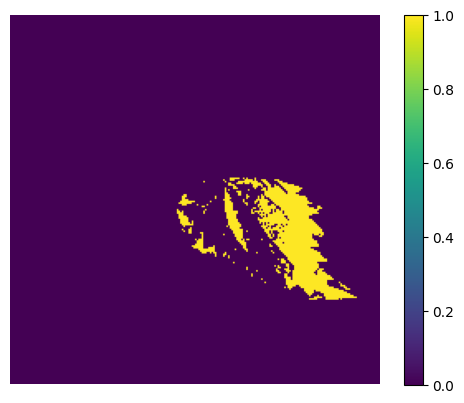

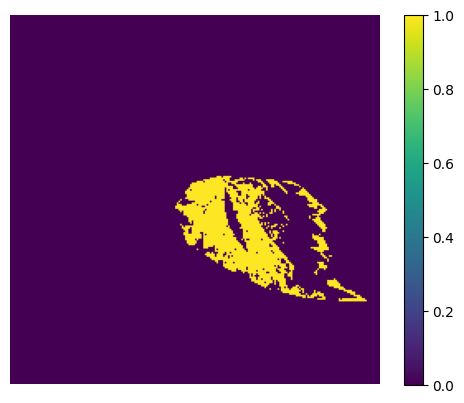

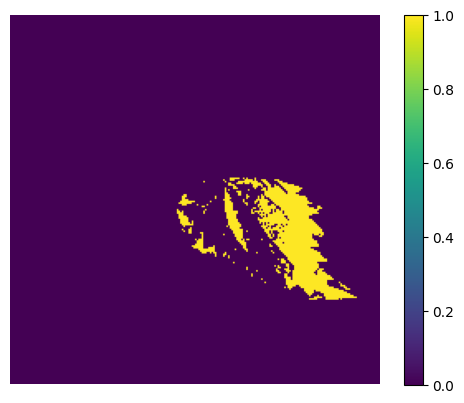

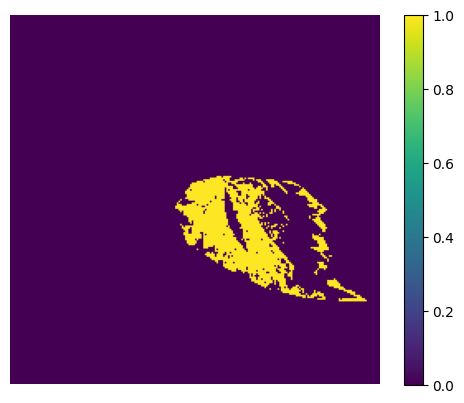

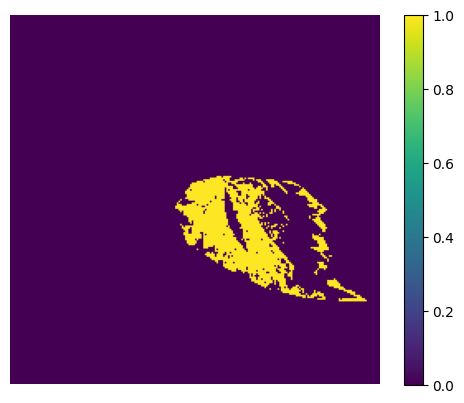

{'compactness': np.float64(285.36006903196784), 'circularity': np.float64(0.0440368922568189), 'entropy': np.float64(0.35867678633202166), 'energy': np.float64(0.9335380019999872), 'eccentricity': 0.8542442969656953, 'homogeneity': np.float64(0.9361166002690764), 'correlation': np.float64(0.7906315890326191), 'target': 'non-mint'}


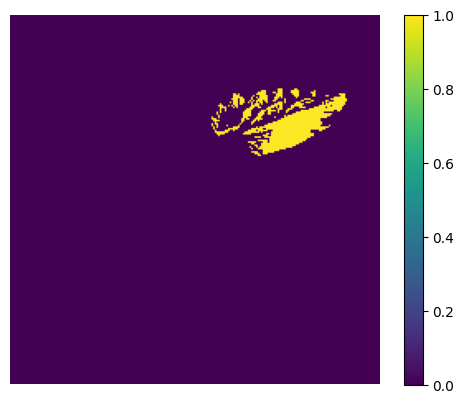

{'compactness': np.float64(16.768915333792762), 'circularity': np.float64(0.749384820915363), 'entropy': np.float64(0.1500855346993431), 'energy': np.float64(0.971853703301449), 'eccentricity': 0.832451576045564, 'homogeneity': np.float64(0.9740895252681644), 'correlation': np.float64(0.8345191477027192), 'target': 'non-mint'}
{'compactness': np.float64(13.236026927438077), 'circularity': np.float64(0.9494065464848278), 'entropy': np.float64(0.00923395305028453), 'energy': np.float64(0.9984385102933768), 'eccentricity': 0.7714870151264323, 'homogeneity': np.float64(0.9985213586649594), 'correlation': np.float64(0.8546196782136362), 'target': 'healthy_apple_mint'}
{'compactness': np.float64(15.975134034407406), 'circularity': np.float64(0.7866206685523638), 'entropy': np.float64(0.03713645942285688), 'energy': np.float64(0.9936939895444248), 'eccentricity': 0.823968543870052, 'homogeneity': np.float64(0.9943497797345486), 'correlation': np.float64(0.9389894978554373), 'target': 'healthy

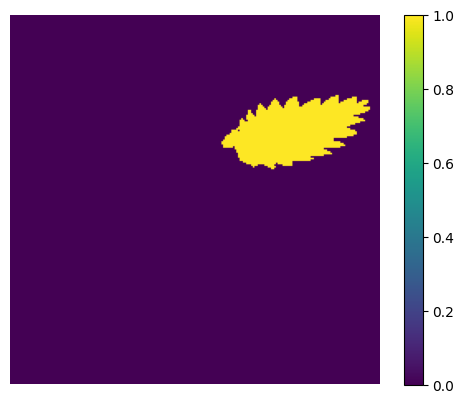

{'compactness': np.float64(45.08410057385293), 'circularity': np.float64(0.278731758078971), 'entropy': np.float64(0.24639616408862036), 'energy': np.float64(0.948873346782306), 'eccentricity': 0.8977167326609895, 'homogeneity': np.float64(0.9559697070679505), 'correlation': np.float64(0.9408368351498186), 'target': 'non-mint'}


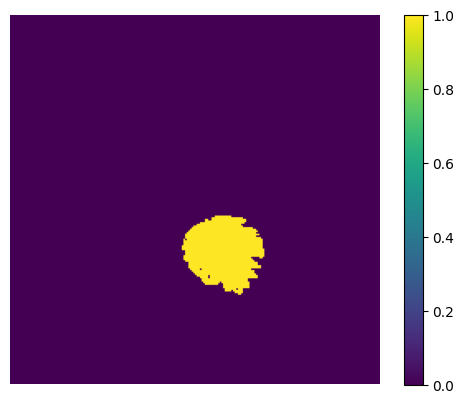

{'compactness': np.float64(27.884541710168655), 'circularity': np.float64(0.4506572403080447), 'entropy': np.float64(0.1696382017732926), 'energy': np.float64(0.9653875450143077), 'eccentricity': 0.42503936655411406, 'homogeneity': np.float64(0.9691694826135622), 'correlation': np.float64(0.948555544736464), 'target': 'non-mint'}


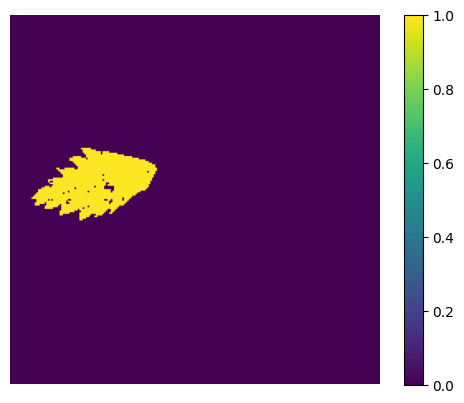

{'compactness': np.float64(71.75257312723491), 'circularity': np.float64(0.1751347731052922), 'entropy': np.float64(0.1964018018940433), 'energy': np.float64(0.9605833679602896), 'eccentricity': 0.8555330841503721, 'homogeneity': np.float64(0.9651722683973223), 'correlation': np.float64(0.9421139035926005), 'target': 'non-mint'}
{'compactness': np.float64(17.620353405778474), 'circularity': np.float64(0.7131735853968808), 'entropy': np.float64(0.14734915585161135), 'energy': np.float64(0.9686712970235811), 'eccentricity': 0.7658452331417882, 'homogeneity': np.float64(0.9746233186170964), 'correlation': np.float64(0.9704320345575645), 'target': 'healthy_apple_mint'}
{'compactness': np.float64(28.300303713583325), 'circularity': np.float64(0.4440365990958492), 'entropy': np.float64(0.2806767175567489), 'energy': np.float64(0.9377639000931773), 'eccentricity': 0.8813388275776042, 'homogeneity': np.float64(0.9503743523791938), 'correlation': np.float64(0.9646281109955462), 'target': 'healt

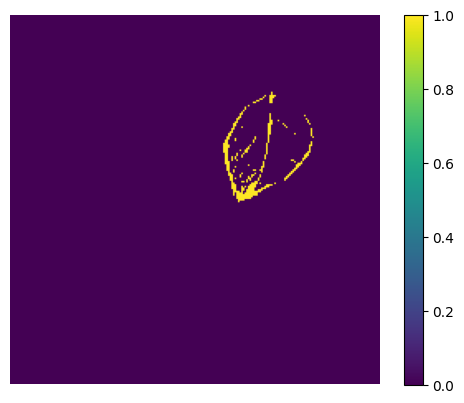

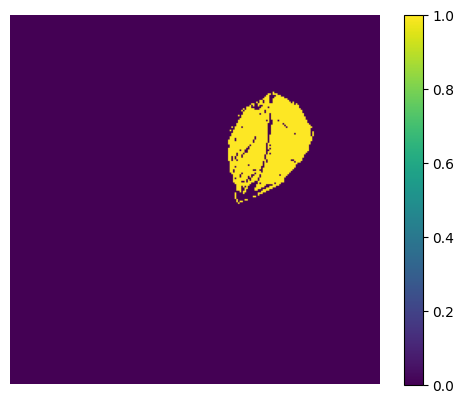

{'compactness': np.float64(134.29670962610294), 'circularity': np.float64(0.09357169397035381), 'entropy': np.float64(0.22679224875587137), 'energy': np.float64(0.9549776933074813), 'eccentricity': 0.6455622059148622, 'homogeneity': np.float64(0.9572702816268406), 'correlation': np.float64(0.8408780287225958), 'target': 'healthy_pepper_mint'}


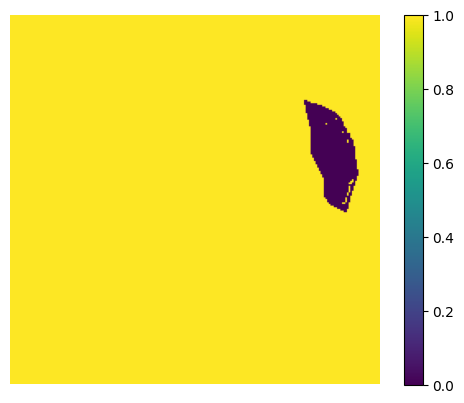

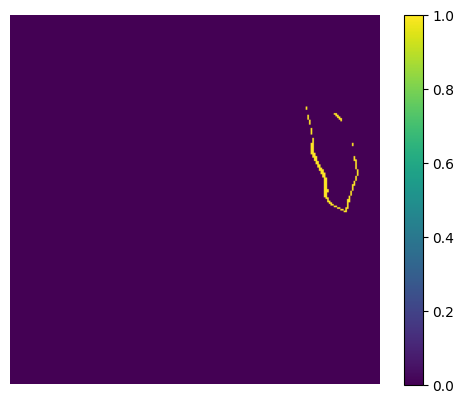

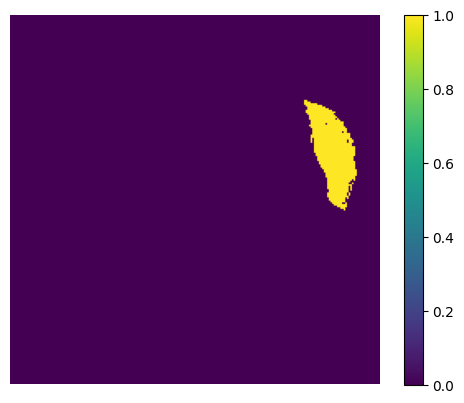

{'compactness': np.float64(37.697116098380235), 'circularity': np.float64(0.333350980524983), 'entropy': np.float64(0.12987480101306415), 'energy': np.float64(0.9755567857917488), 'eccentricity': 0.9349157287242102, 'homogeneity': np.float64(0.9764507756121404), 'correlation': np.float64(0.8850307311712187), 'target': 'healthy_pepper_mint'}
{'compactness': np.float64(15.437594205095827), 'circularity': np.float64(0.8140109428586427), 'entropy': np.float64(0.12415119505159737), 'energy': np.float64(0.9782192457026142), 'eccentricity': 0.757679863888204, 'homogeneity': np.float64(0.9801325523856517), 'correlation': np.float64(0.9725640748714764), 'target': 'healthy_pepper_mint'}
{'compactness': np.float64(17.441449154570982), 'circularity': np.float64(0.7204889056518465), 'entropy': np.float64(0.014134167852295482), 'energy': np.float64(0.9975776887289995), 'eccentricity': 0.9183383205987736, 'homogeneity': np.float64(0.9976539391063229), 'correlation': np.float64(0.7944187832390833), 't

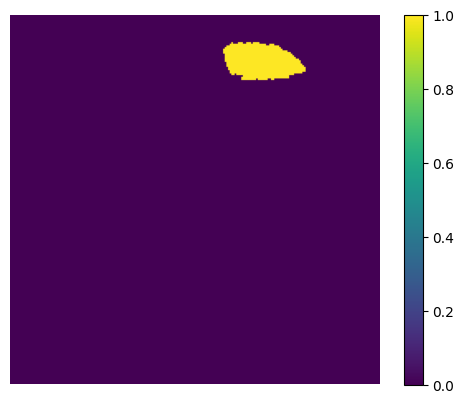

{'compactness': np.float64(20.321210113150006), 'circularity': np.float64(0.618386924026113), 'entropy': np.float64(0.09776838143544525), 'energy': np.float64(0.9820229961840222), 'eccentricity': 0.887814354453371, 'homogeneity': np.float64(0.9837721082104722), 'correlation': np.float64(0.9745392713610612), 'target': 'healthy_pepper_mint'}
{'compactness': np.float64(14.618490767002964), 'circularity': np.float64(0.85962161310962), 'entropy': np.float64(0.028950830223561586), 'energy': np.float64(0.9947550095868234), 'eccentricity': 0.752274388187667, 'homogeneity': np.float64(0.9952309743726181), 'correlation': np.float64(0.9339513833736772), 'target': 'healthy_apple_mint'}
{'compactness': np.float64(13.082047356605377), 'circularity': np.float64(0.960581342645436), 'entropy': np.float64(0.016010301155425757), 'energy': np.float64(0.9973374598188299), 'eccentricity': 0.5226423879899061, 'homogeneity': np.float64(0.9974876320669466), 'correlation': np.float64(0.8856245748126182), 'targe

In [13]:
# class map
# image address map


# every annotation in the annotations list is an object( in our case a leaf ), and it has info about what image 
# the object came from and what is its class
# the image address map will be used here to get the address of the image from image_id and fetch the image
# class_id will be used to give label to the object( leaf ) detect in the feature vector
# segmentations variable stores the x and y coordinate of points on the polygon that surrounds the object
class_map, image_address_map, anno_file_content = annotation_file_info(dataset_path)
feature_list = []

i = 1
for object_annotation in anno_file_content["annotations"]:

    image_address_id = object_annotation["image_id"]
    segmentations = object_annotation["segmentation"]
    class_id = object_annotation["category_id"]
    image_address = image_address_map[image_address_id]



    image = cv2.imread(image_address)

    anno_object = give_annotated_object_area(image, segmentations)


    # preprocessing on the anno_object to isolate the leaf part
    leaf_filter = preprocessing_image(anno_object)


    # fetures to extract
    feature_vector = {}

    leaf_filter_gray = cv2.cvtColor(leaf_filter, cv2.COLOR_BGR2GRAY)
    _, binary_leaf_filter = cv2.threshold(leaf_filter_gray, 1, 255, cv2.THRESH_BINARY)
    show_image(binary_leaf_filter, "binary")

    # it about assigning unique number to each connected componenet in the binary image
    labeled_image = label(binary_leaf_filter)
    props = regionprops(labeled_image)
    leaf_region = props[0]

    compactness, circularity, entropy_value, normal_leaf_image = leaf_region_property(leaf_region, leaf_filter_gray)

    glcm, energy =  _glcm(normal_leaf_image)
    
    eccentricity = leaf_region.eccentricity
    
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    correlation = graycoprops(glcm, 'correlation')[0, 0]

    feature_vector = {
            "compactness": compactness,
            "circularity": circularity,
            "entropy": entropy_value,
            "energy": energy,
            "eccentricity": eccentricity,
            "homogeneity": homogeneity,
            "correlation": correlation,
            "target": class_map[class_id]
        }
    
    print(feature_vector)
    feature_list.append(feature_vector)



In [14]:
print(len(feature_list))

325


In [15]:
import pandas as pd
df = pd.DataFrame(feature_list)

In [16]:
df.to_csv("features.csv", index=False)